# HCI - Spectral Deconvolution
*Matthew Kenworthy // Leiden Observatory*

This week you will look at a data cube taken with the Gemini Planet Imager (GPI) and find a companion in the multiple star system HD 1160.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')

def wfits(im, fname):
    """wfits - write im to file fname, automatically overwriting any old file"""
    from astropy.io import fits
    hea = fits.PrimaryHDU(im)
    hea.writeto(fname, clobber=True)
    
    
def cen_scale (im, sca, dim_out, offset_in=(0,0), offset_out=(0,0), order=2):
    """cen_scale - scales image im at the coordinates of offset1 by factor sca
                   to output image with size dim_out, and puts the point at offset1 
                   in the centre of the output image, with an optional delta offset of offset2
                
                """
    from scipy.ndimage import affine_transform
    # make a scaling matrix
    scale=np.array([[1./sca,0],[0,1./sca]])
    
    # -0.5 is there for fencepost counting error
    c_in = np.array(offset_in) - 0.5

    # c_out already starts at the centre of the output image
    c_out = 0.5 * np.array(dim_out) - 0.5

    # c_out has to be pre-scaled to make offset correct
    offset_combined = c_in - c_out.dot(scale) - np.array(offset_out).dot(scale)
    
    # perform the transformation
    dst=affine_transform( \
        im,scale.T, order=order, offset=offset_combined, \
        output_shape=dim_out, cval=0.0)
    return(dst)

## Showing how `cen_scale` works

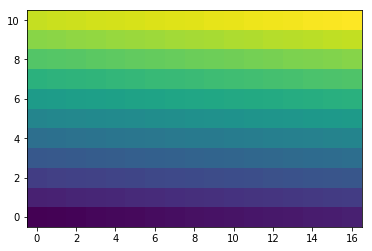

In [2]:
t1 = np.arange(11*17).reshape((11,17))
plt.imshow(t1)

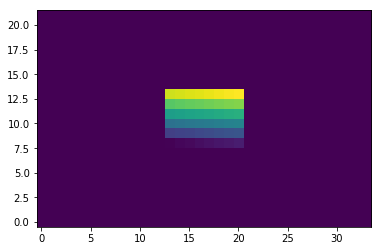

In [3]:
nx, ny = t1.shape
t2 = cen_scale(t1,0.5,(22,34), offset_in=(0.5*nx, 0.5 * ny))
plt.imshow(t2)

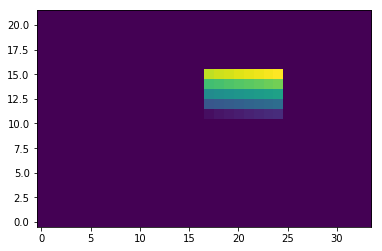

In [4]:
nx, ny = t1.shape
t2 = cen_scale(t1,0.5,(22,34), offset_in=(0,0))
plt.imshow(t2)

In [5]:
def descale(imin, scalefac, out_dims, star_cen):
    """descale - take image imin and a list of magnifications scalefac, and generate an output image of 
       size outdims (where outdims is a tuple) and the scaling is done around the point star_cen.
       star_cen is a tuple of (xstar, ystar) positions and 
       xstar/ystar should be a numpy array or a numpy single value"""
    # get shape of input image
    nim, nx, ny = imin.shape
    
    # sx and sy should be a single pair or contain scalefac.size number of elements
    sx, sy = star_cen
    if (sx.size == 1):
        sx = np.ones_like(scalefac) * sx
    if (sy.size == 1):
        sy = np.ones_like(scalefac) * sy
    
    # make a zero value numpy array for the output
    im_out = np.zeros((nim, out_dims[0], out_dims[1]))
    
    for j, frame in enumerate(np.split(imin, nim, axis=0)):
        frame_sq = np.squeeze(frame)
        frame_rot = cen_scale(frame_sq, scalefac[j], out_dims, offset_in=(sx[j], sy[j]))
        im_out[j,:,:] = frame_rot
        
    return(im_out)    

We read in the data cube consisting of 38 image slices at different wavelengths across the J band.

With FITS files you also have the header information, contained within the variable `he`.

There are keywords and values associated with that keyword, which can be accessed by:

    value = he['keyword']
    
You can print out all the possible keywords with `print he` or examine the FITS file using `ds9`.

In [6]:
im, he = fits.getdata('HD1160_cube.fits', header=True) # HD1160 astrometric
im = np.nan_to_num(im)

## Identifying the main features in the image cube 


There are four 'satellite spots' that are generated by the coronagraph, which act as both astrometric and photometric references for each wavelength slice.

The four spot locations are stored in FITS header with keywords of the form `SATSn_m` where `n` is the image slice from 0 to 37 and `m` is the satellite spot number from 0 to 3.

Display the image at slice index 12 using `imshow()` and a range of 0 to 100.

**Q1 (2 points):** On the same image as above, plot out four circles to mark the four satellite spots.

Use a `for` loop to make the keyword as a formatted string for each spot, then use `np.fromstring()` to split the string into two `numpy` floats for the `x` and `y` coordinates, and then plot a red circle of radius 10 pixels. Use `plt.Circle` to generate a `Circle` object (make sure the Circle is not filled so that you can see the satellite spot), then use `plt.gca().add_artist()` to add the circle to the current plot.

The estimated position of the central star is stored in `PSFCENTX` and `PSFCENTY`. Plot this as a blue circle with a radius of 10 pixels.

**Q2 (2 points)** Write the number of the satellite spot in yellow onto the image using `plt.text()` so that you know which spot is which. Move the text so that it doesn't block out the satellite spot itself.

**Q3 (1 point)** The satellite spot finding algorithm is not perfect, and one of the spots has been misidentified. Which one?


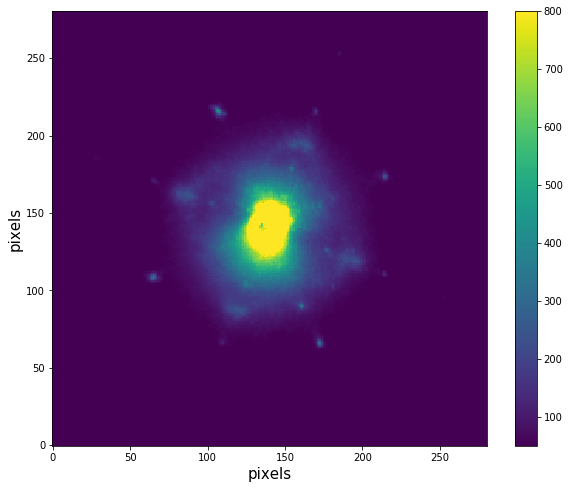

In [7]:
# Q1 to Q3 answers
plt.figure(figsize = (10,8))
#plt.imshow(im[12], vmin = 0, vmax = 100) #It's not a good choice to see the spots
plt.imshow(im[12], vmin = 50, vmax = 800) 
plt.xlabel('pixels', size = 15)
plt.ylabel('pixels', size = 15)
plt.colorbar()

Spot 0, (X,Y) (102.982000, 156.128000)
Spot 1, (X,Y) (131.695000, 110.799000)
Spot 2, (X,Y) (153.538000, 173.343000)
Spot 3, (X,Y) (176.984000, 125.773000)

 Spot number 1 is misidentified


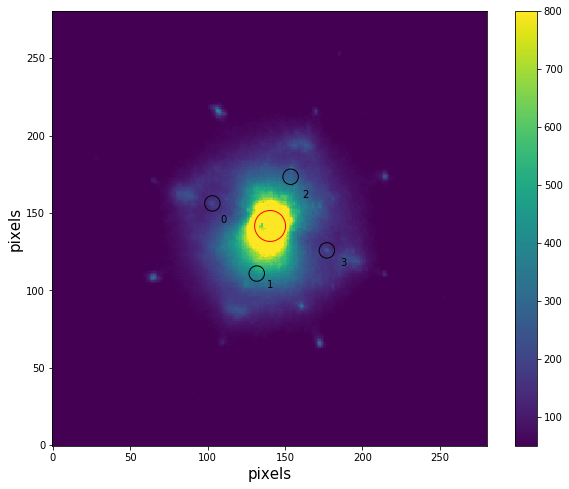

In [8]:
plt.figure(figsize = (10,8))

X_star = he['PSFCENTX']
Y_star = he['PSFCENTY']

for i in range(4):
    #print(he['SATS12_%d'%i])
    [X,Y] = np.fromstring(he['SATS12_%d'%i], dtype = float, sep = ' ')
    print('Spot %i, (X,Y) (%f, %f)'%(i,X,Y))
    
    Circle = plt.Circle((X, Y), 5, color = 'k', fill = False)
    Star   = plt.Circle((X_star, Y_star), 10, color = 'r', fill = False)
    ax = plt.gca()
    #A = ax.imshow(im[12], vmin = 0, vmax = 100)
    A = ax.imshow(im[12], vmin = 50, vmax = 800)
    ax.add_artist(Circle)
    ax.text(X + 0.05*X, Y - 0.08*Y, '%d'%i, color = 'k')
    
ax.add_artist(Star)
ax.set_xlabel('pixels', size = 15)
ax.set_ylabel('pixels', size = 15)
plt.colorbar(A, ax = ax);

print('\n Spot number 1 is misidentified')

## Determining the wavelength for each slice
The wavelength for each slice is stored in two FITS keywords:

`CRVAL3` is the wavelength of slice 0 (call this `wlen0`)

`CD3_3` is wavelength change between each slice (call this `dwlen`).

** Q4 (2 points)** Make a plot of slice number versus wavelength - label the axes as 'Slice number' and 'Wavelength [microns]'

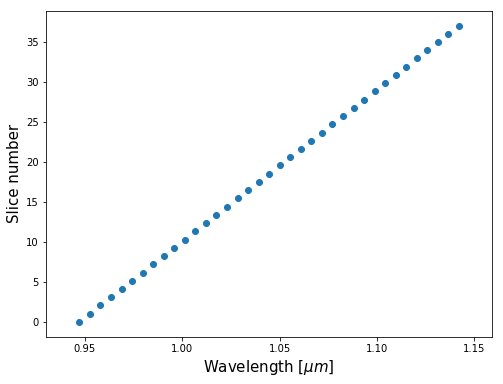

In [9]:
# Q4 answers

wlen0 = he['CRVAL3']
dwlen = he['CD3_3']
#print(wlen0);print(dwlen)

Slice_number = np.linspace(0, 37, 37)
Wavelength = []
for i in range(37):
    Wavelength.append(wlen0 + dwlen*i)
    
Wavelength = np.array(Wavelength)

plt.figure(figsize = (8, 6))    
plt.scatter(Wavelength, Slice_number)
plt.ylabel('Slice number', size = 15)
plt.xlabel(r'Wavelength [$\mu m$]', size = 15);

## Reading in all the spot positions


**Q5 (2 points)** Write a function to read in all x,y values of all satellite spots from the header `he` into two arrays of shape (37,4) and return them, i.e.

    (xspot, yspot) = sat_spot_read(he)
    
**Q6 (2 points)** Use `plt.plot()` to plot out all 4 satellite spots and see how their position changes as a fucntion of wavelength. Label the axes 'X position [pixels]' and 'Y position [pixels]'. **NOTE** The function `plt.plot()` will treat each column along axis 1 as a separate line to plot - you should only have to do `plt.plot(xspot,yspot)` to get the result you want.

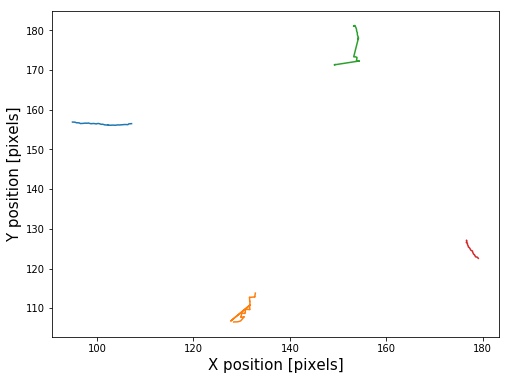

In [10]:
def sat_spot_read(he):
    # SATSn_m with n from 0 to 36 and m from 1 to 4
    ns = 4
    nw = 37
    
    spotx = np.zeros((nw, ns))
    spoty = np.zeros((nw, ns))
    
    for i in range(nw):
        
        for j in range(ns):
            
            X, Y = np.fromstring(he['SATS%d_%d'%(i,j)], dtype = float, sep = ' ')
            spotx[i][j] = X
            spoty[i][j] = Y
    
    # Q5 answer here
    return(spotx, spoty)

x, y = sat_spot_read(he)  

# Q6 answer here
plt.figure(figsize = (8, 6))
plt.plot(x, y)
plt.xlabel('X position [pixels]', size = 15)
plt.ylabel( 'Y position [pixels]', size = 15);

## Variation of PSF center with wavelength

GPI did not have an atmospheric dispersion corrector (ADC) installed when this data was taken, and so the image of the star is smeared out into a spectrum - in other words, the position of the stellar PSF changes with wavelength.

The centre of the stellar PSF is at the midpoint between all four satellite spots, but due to problems with the routine that identified the spots, only spots 0 and 3 can be reliably used. 

**Q7 (2 points)** Calculate the estimated PSF centre for each wavelength slice by finding the average point between the 0 and 3 satellite spots for each wavelength, and plot this value as `star_xcen` versus `star_ycen` in a plot. Label the axes 'Star x position [pixels]' and 'Star y position [pixels]'

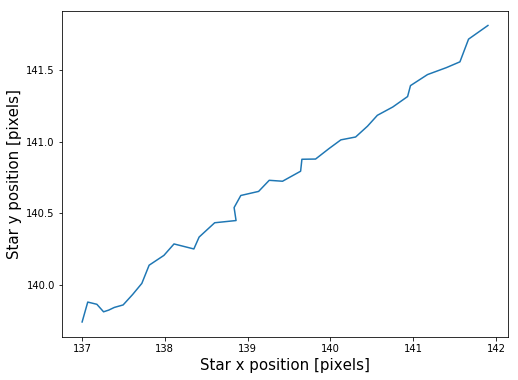

In [11]:
# Q7 answer here

star_xcen = []
star_ycen = []

for i in range(37):
    
    #star_xcen.append( x[i][0] + ( x[i][2] - x[i][0] ) / 2.0 )
    #star_ycen.append( y[i][0] + ( y[i][2] - y[i][0] ) / 2.0 )
    
    star_xcen.append(np.mean([x[i][0], x[i][3]]))
    star_ycen.append(np.mean([y[i][0], y[i][3]]))
    
star_xcen = np.array(star_xcen)
star_ycen = np.array(star_ycen) 

plt.figure(figsize = (8, 6))
plt.plot(star_xcen, star_ycen)
plt.xlabel('Star x position [pixels]', size = 15)
plt.ylabel('Star y position [pixels]', size = 15);

## Comparing the wavelengths

Calculate the separation in pixels between the two satellite spots and call it `spot_separation`. This should be directly proportional to the wavelength of the image slice.

** Q8 (2 points) ** Show that this is true by plotting the image slice wavelength versus the spot separation and label the axes appropriately.


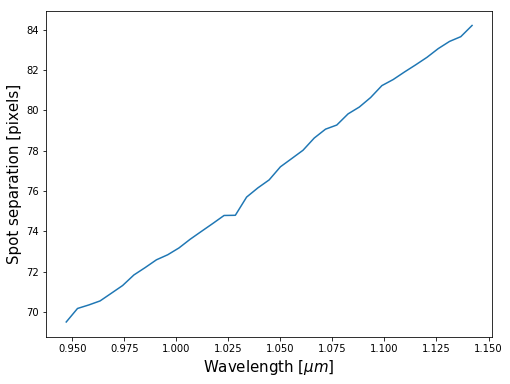

In [12]:
# Q8 answer here

spot_separation = []

for i in range(37):
    
    spot_separation.append(x[i][3] - x[i][0])
    
spot_separation = np.array(spot_separation)  

plt.figure(figsize = (8, 6))
plt.plot(Wavelength, spot_separation)
plt.xlabel(r'Wavelength [$\mu m$]', size = 15)
plt.ylabel('Spot separation [pixels]', size = 15);

## Calculating the magnification needed for aligning the satellite spots

You need a magnification factor for each image so that all the satellite spots are in the same position in the output cube.

We will scale up (upsample) the images to the image with the largest separation between the satellite spots, i.e. the longest wavelength.

Generate the numpy array `mag` that has a magnification of 1.0 for the longest wavelength - all other magnifications should be larger than 1.

** Q9 (2 points) ** Plot out `mag` as a function of frame number and label the axes.

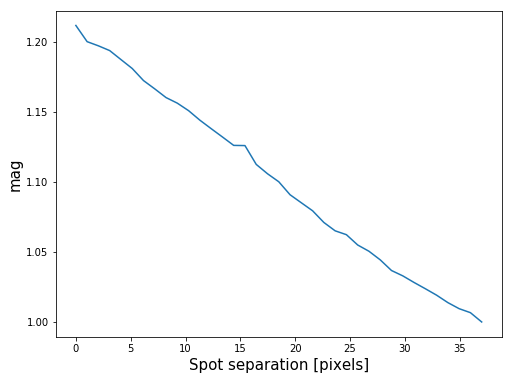

In [13]:
# Q9 answer here

mag = spot_separation[-1] / spot_separation

plt.figure(figsize = (8, 6))
plt.plot(Slice_number, mag)
plt.ylabel('mag', size = 15)
plt.xlabel('Spot separation [pixels]', size = 15);

## Rescaling the data cube to the same $\lambda/D$

With `mag` and the data cube `im` and the centroid of the star in `star_xcen` and `star_ycen`, you can now rescale all image slices to the same $\lambda/D$ resolution.

** Q10 (2 points) ** Use `descale()` to make a data cube that is 250 by 250 pixels in size, and where each image is magnified by a factor of `mag` and call it `sdi1`.

Write this image cube out to `sdi1_cube.fits` and use ds9 to convince yourself that all the images have the satellite spots in the same x,y positions in the cube.

**REMINDER** x and y positions in numpy arrays are usually the other way around...

In [14]:
# Q10 answer here

scalefac = mag
out_dims = (250, 250)
star_cen = (star_ycen, star_xcen)

sdi1 = descale(im, scalefac, out_dims, star_cen)
wfits(sdi1, 'sdi1_cube.fits')

## Calculate the flux normalisation

The throughput of the instrument varies as a function of wavelength, so you need to estimate the throughput by looking at one of the satellite spots and adding up the flux with a box centered on one of the satellite spots.

Pick the satellite spot at around 170, 110 (but CHECK that it is there first! Do not assume I am giving you the exact values... you should be tinking of sensible checks for what I tell you) and sum up the flux in each image slice on a box centered on this satellite spot, with a box width of 10 pixels. 

Call this `spot_sum`

** Q11 (2 points) ** Plot out the flux as a function of wavelength and label the axes appropriately.

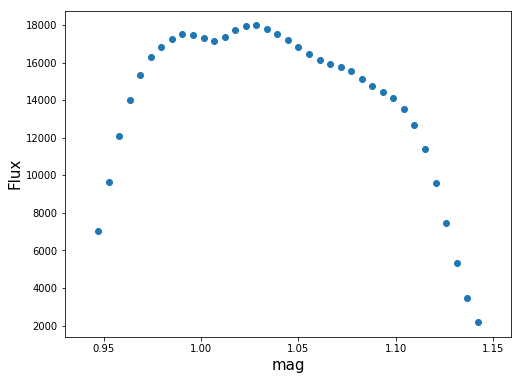

In [15]:
# Q11 answer here
im_1, he_1 = fits.getdata('sdi1_cube.fits', header=True) # HD1160 astrometric NEW-Cube
im_1 = np.nan_to_num(im_1)

spot_sum = []

for i in range(37):
    
    spot_sum.append(np.sum(im_1[i][108-5:108+5,167-5:167+5])) 
    
spot_sum = np.array(spot_sum)

plt.figure(figsize = (8, 6))
plt.scatter(Wavelength, spot_sum);
plt.xlabel('mag', size = 15)
plt.ylabel('Flux', size = 15);

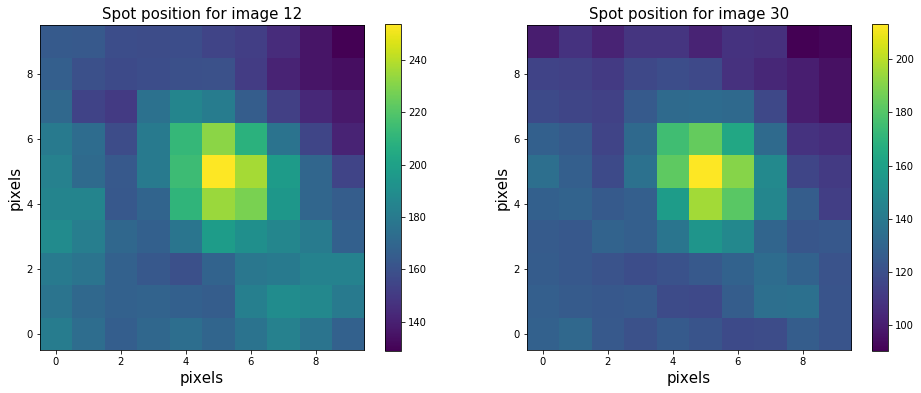

In [16]:
#Sanity check: The spots should remain in the same box position in different images

fig, ((axA, axB)) = plt.subplots(figsize = (16, 6), ncols = 2, nrows = 1)

A = axA.imshow(im_1[12][108-5:108+5,167-5:167+5])
axA.set_xlabel('pixels', size = 15)
axA.set_ylabel('pixels', size = 15)
axA.set_title('Spot position for image 12', size = 15)
plt.colorbar(A, ax = axA)

B = axB.imshow(im_1[30][108-5:108+5,167-5:167+5])
axB.set_xlabel('pixels', size = 15)
axB.set_ylabel('pixels', size = 15)
axB.set_title('Spot position for image 30', size = 15)
plt.colorbar(B, ax = axB)

## Normalise the `sdi1` cube

Normalise the `sdi1` cube by the summed flux (don't worry about normalising the whole flux curve, we'll be dividing it out again in a minute) and call it `sdi1_norm`.

Write this out to a FITS file and make a sanity check that you've got approximately the same flux in the satellite spots.


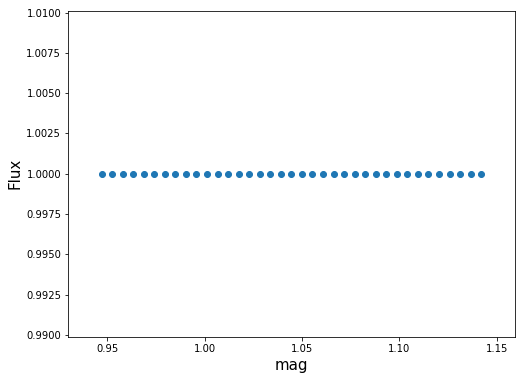

In [17]:
#
sdi1_norm = []

for i in range(37):
    sdi1_norm.append(im_1[i] / spot_sum[i])
    
wfits(sdi1_norm, 'sdi1_norm_cube.fits')

sdi1_norm = np.array(sdi1_norm)

#Sanity check for the normalization
spot_sum_2 = []
 
for i in range(37):
    
    spot_sum_2.append(np.sum(sdi1_norm[i][108-5:108+5,167-5:167+5])) 
    
spot_sum_2 = np.array(spot_sum_2)

plt.figure(figsize = (8, 6))
plt.scatter(Wavelength, spot_sum_2);
plt.xlabel('mag', size = 15)
plt.ylabel('Flux', size = 15);

## Removing the diffraction structures

Taking the median of `sdi1_norm` then removes the planet, leaving all the diffraction structures in place.

Take the median of `sdi1_norm` and subtract it off the individual frames in `sdi1_norm`, and call this `sdi1_norm_sub`

Remove the flux normalisation by multiplying `sdi1_norm_sub` by `spot_sum`.

In [18]:
#
Median          = np.median(sdi1_norm, axis = 0)
sdi1_norm_sub_2 = np.array(sdi1_norm - Median)

sdi1_norm_sub = []

for i in range(37):
    sdi1_norm_sub.append(sdi1_norm_sub_2[i] * spot_sum[i])
    
sdi1_norm_sub = np.array(sdi1_norm_sub)    

## Scale back to the sky plate scale
The last part of SDI is to demagnify the image cube and take the mean of the cube to see the planet.

Remember that you can use `descale()` to unmagnify the image frames, but now move the star to be at the centre of a 250 by 250 pixel array. Call this `sdi_out`.

In [19]:
#
scalefac = 1.0 / mag
out_dims = (250, 250)
star_cen = (np.array(125), np.array(125))

sdi_out = descale(sdi1_norm_sub, scalefac, out_dims, star_cen)
wfits(sdi_out, 'sdi_out.fits')

## Display the planet

** Q12 (2 points)** Take the mean of all the images in `sdi_out` and display the image with a range of -10 to 200. What is the approximate position of the companion with respect to the central star?

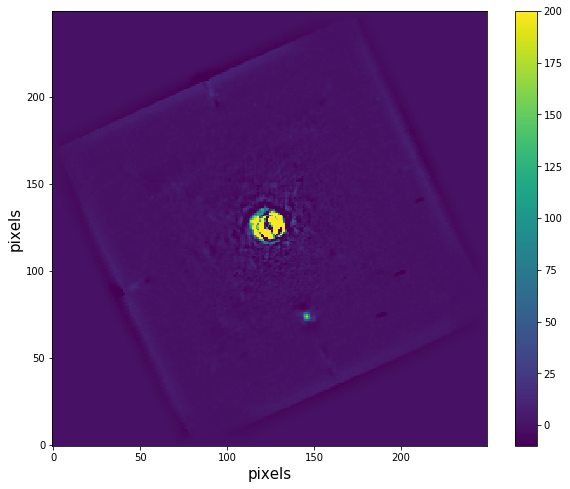

In [20]:
# Q12 answer here

Mean_final = np.mean(sdi_out, axis  = 0)

plt.figure(figsize = (10,8))
#plt.imshow(Mean_final[24:125,96:197], vmin = -10, vmax = 200)
plt.imshow(Mean_final, vmin = -10, vmax = 200)
plt.xlabel('pixels', size = 15)
plt.ylabel('pixels', size = 15)
plt.colorbar();

In [21]:
PScale = 0.0143 #arcsec/px

X_star   = 127.0 ; Y_star   = 127.0 #From Mean_final in DS9
X_planet = 145.0 ; Y_planet = 75.0

Separation_pixels = np.sqrt( (X_star - X_planet)**2 + (Y_star - Y_planet)**2 )

Separation_arcsec = Separation_pixels*PScale

print('The separation in arcsec is: %.3f'%Separation_arcsec)

D_star = 103.5 #Distance in pc to the star

Separation_au = D_star * Separation_arcsec

print('The separation in astronomical units is: %.3f'%Separation_au)

The separation in arcsec is: 0.787
The separation in astronomical units is: 81.443
